In [1]:
import glob
import unicodedata
import string

In [2]:
def find_files(path): return glob.glob(path)
print(find_files('./data/names/*.txt'))

['./data/names/Arabic.txt', './data/names/English.txt', './data/names/German.txt', './data/names/Vietnamese.txt', './data/names/Italian.txt', './data/names/Czech.txt', './data/names/Scottish.txt', './data/names/Dutch.txt', './data/names/Korean.txt', './data/names/Chinese.txt', './data/names/Greek.txt', './data/names/Irish.txt', './data/names/French.txt', './data/names/Portuguese.txt', './data/names/Russian.txt', './data/names/Japanese.txt', './data/names/Polish.txt', './data/names/Spanish.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # plus EOS marker

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode2ascii(line) for line in lines]

print(unicode2ascii("Ślusàrski"))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

for filename in find_files('./data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
print("# categories: ", n_categories, all_categories)
print("Korean Samples", category_lines['Korean'][:5])

# categories:  18 ['Arabic', 'English', 'German', 'Vietnamese', 'Italian', 'Czech', 'Scottish', 'Dutch', 'Korean', 'Chinese', 'Greek', 'Irish', 'French', 'Portuguese', 'Russian', 'Japanese', 'Polish', 'Spanish']
Korean Samples ['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [7]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [8]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [9]:

# Make category, input, and target tensors from a random category, line pair
def randomTrainingSet():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

In [10]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()

    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

In [11]:

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
rnn = RNN(n_letters, 128, n_letters)

n_epochs = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every epochs

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = train(*randomTrainingSet())
    total_loss += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 19s (5000 5%) 2.6837
0m 37s (10000 10%) 1.9344
1m 2s (15000 15%) 3.1829
1m 20s (20000 20%) 2.0901
1m 37s (25000 25%) 2.2600
1m 54s (30000 30%) 2.4768
2m 11s (35000 35%) 1.9242
2m 48s (40000 40%) 3.0706
3m 19s (45000 45%) 2.1971
3m 56s (50000 50%) 2.3001
4m 32s (55000 55%) 2.4356
5m 5s (60000 60%) 2.7043
5m 41s (65000 65%) 2.8568
6m 25s (70000 70%) 2.9467
6m 53s (75000 75%) 2.4472
7m 26s (80000 80%) 2.0377
7m 50s (85000 85%) 2.0354
8m 14s (90000 90%) 2.9155
8m 37s (95000 95%) 2.5176
9m 0s (100000 100%) 3.0529


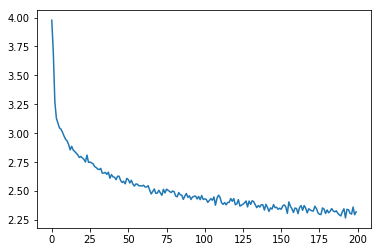

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [33]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.init_hidden()

    output_name = start_letter
    
    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:    
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [34]:
samples('Russian', 'RUS')



Columns 0 to 7 
 -4.3618  -6.4685  -5.5572  -5.7780  -2.1311  -5.1758  -7.2366  -4.3618

Columns 8 to 15 
 -2.9089  -7.3804  -4.3618  -5.5018  -6.8049  -5.3581  -2.0561  -6.3749

Columns 16 to 23 
 -7.7400  -5.7679  -3.7401  -5.3510  -5.2909  -4.5763  -8.6225  -7.6426

Columns 24 to 31 
 -3.7029  -6.6118 -10.0374  -4.3618 -10.0299 -10.1536 -10.5617 -10.0057

Columns 32 to 39 
-10.6159 -10.1043 -10.2568 -10.3292  -9.9136 -10.1090  -9.8665 -10.0643

Columns 40 to 47 
-10.1542 -10.2233 -10.2552 -10.0955  -4.3618  -4.3618 -10.3225 -10.1535

Columns 48 to 55 
-10.3798  -4.3618  -9.4846 -10.5004  -7.8044 -10.5546 -10.3649  -4.3618

Columns 56 to 58 
 -4.3618  -9.6946  -0.7309
[torch.FloatTensor of size 1x59]

Rovakov


Columns 0 to 7 
 -2.6788  -5.9787  -4.0485  -4.0485  -2.2653  -4.7267  -5.9963  -4.4737

Columns 8 to 15 
 -3.3885  -6.3507  -4.4089  -4.0485  -6.3201  -4.9112  -2.5057  -4.0485

Columns 16 to 23 
 -7.1685  -4.9019  -3.3162  -4.0485  -5.5367  -4.3063  -7.7782  -7.0433

Colum

In [30]:
samples('German', 'GER')

Garten
Eren
Roure


In [31]:
samples('Korean', 'KOR')

Kon
Oo
Ro


In [32]:
samples('Chinese', 'CHI')

Can
Han
Iun
